#CNN

# Load Dataset

In [2]:
#Menyambungkan dataset pada laman Kaggle
#jangan lupa file json
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:25<00:00, 44.6MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.6MB/s]


In [7]:
#Unzip Data
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"

with ZipFile(file_name,'r') as zip :
  zip.extractall()
  print('Berhasil')

Berhasil


#Preprocessing

In [8]:
#Import library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [9]:
#Pengambilan Data
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
#Inisialisasi Path
train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


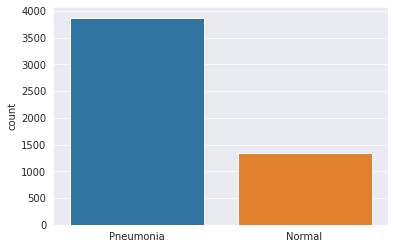

In [11]:
#Analisis Data
cekData = []
for i in train:
    if(i[1] == 0):
        cekData.append("Pneumonia")
    else:
        cekData.append("Normal")
sns.set_style('darkgrid')
sns.countplot(cekData) 

Imbalance Dataset


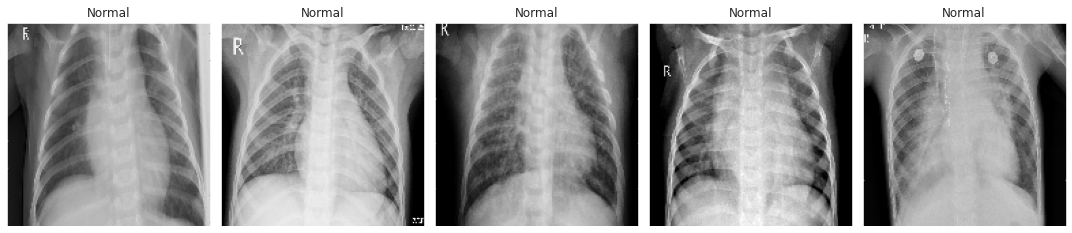

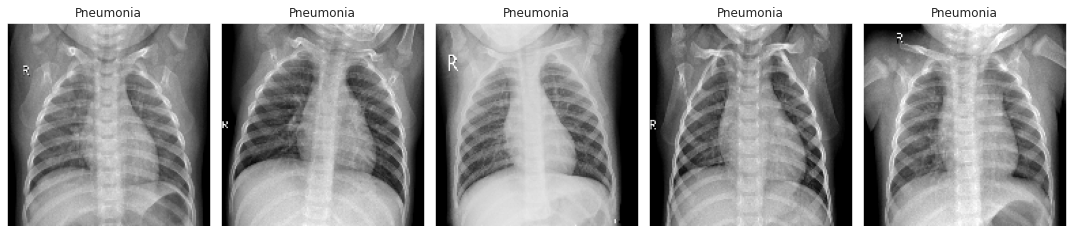

In [12]:
#Print sampel data dari masing masing label
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
        img = train[i][0]
        ax.imshow(img, cmap='gray')
        ax.set_title("Normal")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
        img = train[-(i+1)][0]
        ax.imshow(img, cmap='gray')
        ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

# Augmentasi & Normalisasi

Data Augmentation

Tujuan :
1. Menghindari overfitting
2. Handling unbalance dataset
3. Menghasilkan model yang konsisten

In [13]:
#Splitting Data
#X = Fitur
#Y = Label
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [14]:
#Normalisasi Data
#Biar dalam rentang 0-1
x_train = np.array(x_train) / 255 #255 = nilai max
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [15]:
#Resize Data
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [17]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

In [18]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(y_train)

[0 0 0 ... 1 1 1]


# Modelling

## Modelling Scenario 1

In [19]:
model = Sequential()

model.add(InputLayer(input_shape=[150, 150, 1]))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(GlobalMaxPooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        1

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [33]:
model_1 = model.fit(x_train, y_train, batch_size=20, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
261/261 [==============================] - 7s 27ms/step - loss: 0.0778 - acc: 0.9688 - val_loss: 1.9173 - val_acc: 0.6330
Epoch 2/200
261/261 [==============================] - 7s 26ms/step - loss: 0.0803 - acc: 0.9672 - val_loss: 0.8164 - val_acc: 0.7228
Epoch 3/200
261/261 [==============================] - 7s 26ms/step - loss: 0.0631 - acc: 0.9735 - val_loss: 1.3987 - val_acc: 0.6779
Epoch 4/200
261/261 [==============================] - 7s 26ms/step - loss: 0.0614 - acc: 0.9766 - val_loss: 1.2526 - val_acc: 0.6939
Epoch 5/200
261/261 [==============================] - 7s 26ms/step - loss: 0.0539 - acc: 0.9770 - val_loss: 1.8776 - val_acc: 0.6619
Epoch 6/200
261/261 [==============================] - 7s 26ms/step - loss: 0.0842 - acc: 0.9668 - val_loss: 1.1787 - val_acc: 0.6907
Epoch 7/200
261/261 [==============================] - 7s 26ms/step - loss: 0.0533 - acc: 0.9774 - val_loss: 1.0286 - val_acc: 0.7212
Epoch 8/200
261/261 [==============================] - 7s 26ms

## Modelling Scenario 2

In [34]:
mod = Sequential()

mod.add(InputLayer(input_shape=[150, 150, 1]))
mod.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
mod.add(Dropout(0.2))
mod.add(AveragePooling2D(pool_size=2, padding='same'))

mod.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
mod.add(Dropout(0.2))
mod.add(AveragePooling2D(pool_size=2, padding='same'))

mod.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
mod.add(Dropout(0.2))
mod.add(AveragePooling2D(pool_size=2, padding='same'))

mod.add(GlobalAveragePooling2D())
mod.add(Flatten())

mod.add(Dense(128, activation='relu'))
mod.add(Dense(1, activation='sigmoid'))

In [35]:
print(mod.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 16)      160       
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 150, 16)      0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
dropout_10 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 38, 38, 64)       

In [36]:
mod.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [37]:
model_2 = mod.fit(x_train, y_train, batch_size=20, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
261/261 [==============================] - 8s 26ms/step - loss: 0.5681 - acc: 0.7419 - val_loss: 0.7583 - val_acc: 0.6250
Epoch 2/200
261/261 [==============================] - 6s 25ms/step - loss: 0.4903 - acc: 0.7429 - val_loss: 0.7082 - val_acc: 0.6250
Epoch 3/200
261/261 [==============================] - 7s 25ms/step - loss: 0.4659 - acc: 0.7431 - val_loss: 0.7489 - val_acc: 0.6250
Epoch 4/200
261/261 [==============================] - 6s 25ms/step - loss: 0.3894 - acc: 0.8039 - val_loss: 0.7494 - val_acc: 0.6747
Epoch 5/200
261/261 [==============================] - 6s 25ms/step - loss: 0.3477 - acc: 0.8388 - val_loss: 0.6282 - val_acc: 0.7196
Epoch 6/200
261/261 [==============================] - 6s 25ms/step - loss: 0.3202 - acc: 0.8514 - val_loss: 0.5171 - val_acc: 0.7516
Epoch 7/200
261/261 [==============================] - 7s 25ms/step - loss: 0.2860 - acc: 0.8738 - val_loss: 0.4657 - val_acc: 0.7788
Epoch 8/200
261/261 [==============================] - 7s 25ms

# Loss & Accuracy Plot

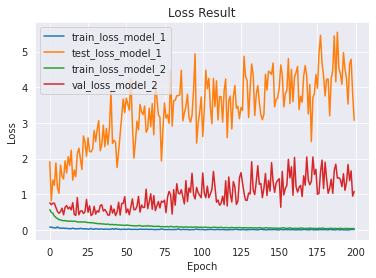

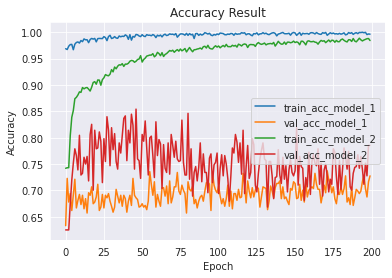

In [38]:
import matplotlib.pyplot as plt

plt.plot(model_1.history["loss"], label="train_loss_model_1")
plt.plot(model_1.history["val_loss"], label="test_loss_model_1")
plt.plot(model_2.history["loss"], label="train_loss_model_2")
plt.plot(model_2.history["val_loss"], label="val_loss_model_2")
plt.title("Loss Result")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(model_1.history["acc"], label="train_acc_model_1")
plt.plot(model_1.history["val_acc"], label="val_acc_model_1")
plt.plot(model_2.history["acc"], label="train_acc_model_2")
plt.plot(model_2.history["val_acc"], label="val_acc_model_2")
plt.title("Accuracy Result")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Saving Model

In [41]:
base_path = 'model'
project_name = 'all_models'
save_model = 'model_2.h5'
model_path = os.path.join(base_path, project_name, save_model)

if os.path.exists(os.path.join(base_path, project_name)) == False:
  os.makedirs(os.path.join(base_path, project_name))

mod.save(save_model, include_optimizer=False)
print('Model has been saved!')

Model has been saved!
